In [1]:
import itertools
import time

import numpy as np
import pandas as pd
import yaml
import matplotlib.pyplot as plt

In [2]:
def demand_function(price, c, d):
    """
    Demand function based on price elasticity parameters.

    See: https://www.econstor.eu/bitstream/10419/286380/1/1856454916.pdf for
        an example of the log function.
    """
    demand_max = np.exp(c * np.log(0.001) + d)
    if price == 0:
        return demand_max
    return min(demand_max, np.exp(c * np.log(price) + d))

def estimate_demand_params(p1, q1, p2, q2):
    """
    Estimate the demand function parameters c and d using linear regression
    on the log-log transformed data.

    """
    A = np.array([[np.log(p1), 1],
                  [np.log(p2), 1]])
    b = np.array([np.log(q1), np.log(q2)])
    c, d = np.linalg.solve(A, b)
    return c, d

class Tariff:
    def __init__(self, onpeak_price, offpeak_price, fixed_charge,
                 market_price_offpeak, market_price_onpeak):
        """
        :param float onpeak_price: dollars per kWh for peak hours
        :param float offpeak_price: dollars per kWh for offpeak hours
        :param float fixed_charge: fixed charge
        :param float market_price_offpeak: market energy price for offpeak hours
        :param float market_price_onpeak: market energy price for onpeak hours
        """
        self.onpeak_price = onpeak_price
        self.offpeak_price = offpeak_price
        self.fixed_charge = fixed_charge
        self.market_price_offpeak = market_price_offpeak
        self.market_price_onpeak = market_price_onpeak

    def consumption(self, customer):
        """
        Calculate the consumption for the customer.
        """
        consumed_onpeak = customer.demand_peak(self.onpeak_price)
        consumed_offpeak = customer.demand_offpeak(self.offpeak_price)
        return consumed_onpeak, consumed_offpeak

    def bill(self, customer):
        """
        Calculate the bill for the customer.
        """
        consumed_onpeak, consumed_offpeak = self.consumption(customer)
        return (
            self.fixed_charge + consumed_onpeak * self.onpeak_price +
            consumed_offpeak * self.offpeak_price
        )

    def simplicity(self):
        """
        Calculate the simplicity of the tariff. This ranges from 0 to 100
        (most simple)
        """
        if self.onpeak_price == 0 and self.offpeak_price == 0:
            return 100
        if self.onpeak_price == self.offpeak_price:
            return 90
        # Normalize by the difference between the peak on offpeak...
        return 80 - 80 * (self.onpeak_price - self.offpeak_price) / self.onpeak_price

    def profit(self, customer):
        """
        Calculate the profit for the utility.
        """
        return (
            self.bill(customer) -
            customer.demand_peak(self.market_price_onpeak) * self.market_price_onpeak +
            customer.demand_offpeak(self.market_price_offpeak) * self.market_price_offpeak
        )

    def __str__(self):
        return f'Tariff(peak={self.onpeak_price}, offpeak={self.offpeak_price}, fixed_charge={self.fixed_charge})'


class Customer:
    """
    Model of a customer class.
    """
    def __init__(self, peak_consumption, offpeak_consumption,
                 peak_price, offpeak_price, peak_elasticity=-0.6,
                 offpeak_elasticity=-0.2):
        """
        :param float peak_consumption: peak consumption (kWh)
        :param float offpeak_consumption: offpeak consumption (kWh)
        :param float peak_price: default price for peak hours ($/kWh)
        :param float offpeak_price: default price for offpeak hours ($/kWh)
        :param float elasticity: price elasticity of demand
        """
        self.peak_consumption = peak_consumption
        self.offpeak_consumption = offpeak_consumption
        self.peak_price = peak_price
        self.offpeak_price = offpeak_price
        self.peak_elasticity = peak_elasticity
        self.offpeak_elasticity = offpeak_elasticity

        self.c_peak, self.d_peak = estimate_demand_params(
            self.peak_price, self.peak_consumption,
            self.peak_price * 1.01, self.peak_consumption * (1 + self.peak_elasticity * 0.01)
        )
        self.c_offpeak, self.d_offpeak = estimate_demand_params(
            self.offpeak_price, self.offpeak_consumption,
            self.offpeak_price * 1.01, self.offpeak_consumption * (1 + self.offpeak_elasticity * 0.01)
        )

    def demand_peak(self, price):
        return demand_function(price, self.c_peak, self.d_peak)

    def demand_offpeak(self, price):
        return demand_function(price, self.c_offpeak, self.d_offpeak)


In [3]:
customer = Customer(peak_consumption=5 * 30, offpeak_consumption=1 * 30,
                    peak_price=0.15, offpeak_price=0.15)

print('peak demand:', customer.demand_peak(0.30))
print('offpeak demand:', customer.demand_offpeak(0.05))

tariff = Tariff(onpeak_price=0.30, offpeak_price=0.05, fixed_charge=20,
                market_price_offpeak=0.05, market_price_onpeak=0.80)

print('profit:', tariff.profit(customer))

peak demand: 98.63360860377887
offpeak demand: 37.42121328951404
profit: 9.732432141019661


In [4]:
def make_tariff_set(customer, market_price_offpeak, market_price_onpeak,
                    fixed_charges, onpeak_prices, offpeak_prices):
    """
    Make a set of tariffs for the customer.
    """
    output = []
    tariff_book = []

    total_combos = len(fixed_charges) * len(onpeak_prices) * len(offpeak_prices)
    print(f"Generating {total_combos} tariffs...")
    count = 0
    iterate = 0
    start = time.monotonic()
    for fixed_charge, onpeak_price, offpeak_price in itertools.product(
            fixed_charges, onpeak_prices, offpeak_prices):
        iterate += 1
        if offpeak_price > onpeak_price:
            continue
        tariff = Tariff(onpeak_price, offpeak_price, fixed_charge,
                        market_price_offpeak, market_price_onpeak)
        if tariff.profit(customer) < 30:
            continue

        tariff_result = {}
        tariff_result['bill'] = tariff.bill(customer)
        tariff_result['profit'] = tariff.profit(customer)
        tariff_result['consumed_peak'] = customer.demand_peak(onpeak_price)
        tariff_result['consumed_offpeak'] = customer.demand_offpeak(offpeak_price)
        tariff_result['simplicity'] = tariff.simplicity()

        tariff_id = f"T{count:010d}"

        tariff_result['tariff_id'] = tariff_id


        output.append(tariff_result)
        tariff_book.append([onpeak_price, offpeak_price, fixed_charge])
        count += 1
        if count % 20000 == 0:
            print(f"Generated {count} of {total_combos} tariffs...")
            elapsed = time.monotonic() - start
            print("Elapsed time: ", elapsed, "seconds")
            print("Estimated time to completion: ",
                  round((total_combos - iterate) * elapsed / iterate, 2), "seconds")
    print("Valid tariffs: ", len(output))
    print("Done.")

    return output, pd.DataFrame(
        tariff_book, columns=['onpeak_price', 'offpeak_price', 'fixed_charge'],
        index=[k['tariff_id'] for k in output])

In [5]:
price_options = np.arange(0.00, 0.31, 0.05)
fixed_charges = np.arange(0, 100, 10)

tariff_set, tariff_book = make_tariff_set(
    customer, 0.05, 0.80, fixed_charges=fixed_charges,
    onpeak_prices=price_options.copy(), offpeak_prices=price_options.copy())

tariff_set_df = pd.DataFrame(tariff_set)
tariff_set_df.set_index('tariff_id', inplace=True)
# Merge the tariff book with the tariff set.
tariff_set_df = pd.merge(tariff_set_df, tariff_book, left_index=True, right_index=True)


Generating 490 tariffs...
Valid tariffs:  141
Done.


In [10]:
tariff_set_df.head(30)

,bill,profit,consumed_peak,consumed_offpeak,simplicity,onpeak_price,offpeak_price,fixed_charge
tariff_id,,,,,,,,
T0000000000,72.033070,30.304359,110.132281,30.000000,48.000000,0.25,0.15,40
T0000000001,73.195641,31.466930,110.132281,28.312853,64.000000,0.25,0.20,40
T0000000002,74.300525,32.571814,110.132281,27.069820,90.000000,0.25,0.25,40
T0000000003,72.845081,31.116370,98.633609,32.549982,26.666667,0.30,0.10,40
T0000000004,74.090083,32.361371,98.633609,30.000000,40.000000,0.30,0.15,40
T0000000005,75.252653,33.523942,98.633609,28.312853,53.333333,0.30,0.20,40
T0000000006,76.357538,34.628827,98.633609,27.069820,66.666667,0.30,0.25,40
T0000000007,77.418526,35.689814,98.633609,26.094810,90.000000,0.30,0.30,40
T0000000008,72.423724,30.695013,191.687255,32.549982,90.000000,0.10,0.10,50


,onpeak_consumption,offpeak_consumption,bill,emissions,onpeak_credit_costs,offpeak_credit_costs,total_credit_costs,profit,bill_disapproval,co2_disapproval,approval_co2_zero,approval,onpeak_price,offpeak_price,fixed_charge
tariff_id,,,,,,,,,,,,,,,
T0000000007,98.633609,26.094810,77.418526,22336.202711,9.863361,1.304740,11.168101,35.689814,38.709263,22.336203,51.290737,28.954535,0.30,0.30,40
T0000000002,110.132281,27.069820,74.300525,24733.438180,11.013228,1.353491,12.366719,32.571814,37.150263,24.733438,52.849737,28.116299,0.25,0.25,40
T0000000030,98.633609,26.094810,87.418526,22336.202711,9.863361,1.304740,11.168101,45.689814,43.709263,22.336203,46.290737,23.954535,0.30,0.30,50
T0000000023,110.132281,27.069820,84.300525,24733.438180,11.013228,1.353491,12.366719,42.571814,42.150263,24.733438,47.849737,23.116299,0.25,0.25,50
T0000000017,126.045371,28.312853,80.871645,28040.359538,12.604537,1.415643,14.020180,39.142934,40.435822,28.040360,49.564178,21.523818,0.20,0.20,50
T0000000057,98.633609,26.094810,97.418526,22336.202711,9.863361,1.304740,11.168101,55.689814,48.709263,22.336203,41.290737,18.954535,0.30,0.30,60
T0000000012,150.000000,30.000000,77.000000,33000.000000,15.000000,1.500000,16.500000,35.271289,38.500000,33.000000,51.500000,18.500000,0.15,0.15,50
T0000000050,110.132281,27.069820,94.300525,24733.438180,11.013228,1.353491,12.366719,52.571814,47.150263,24.733438,42.849737,18.116299,0.25,0.25,60
T0000000044,126.045371,28.312853,90.871645,28040.359538,12.604537,1.415643,14.020180,49.142934,45.435822,28.040360,44.564178,16.523818,0.20,0.20,60


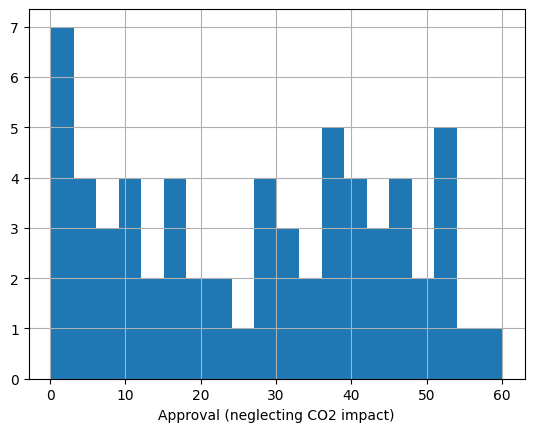

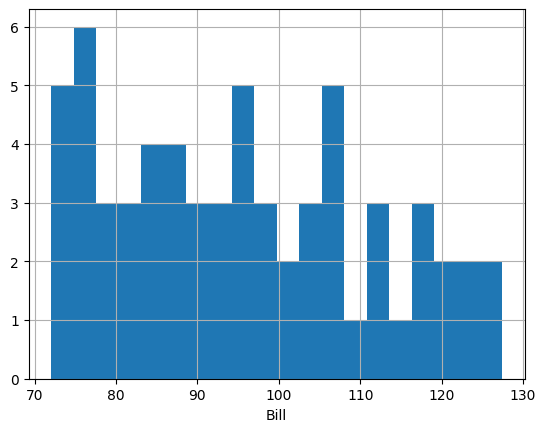

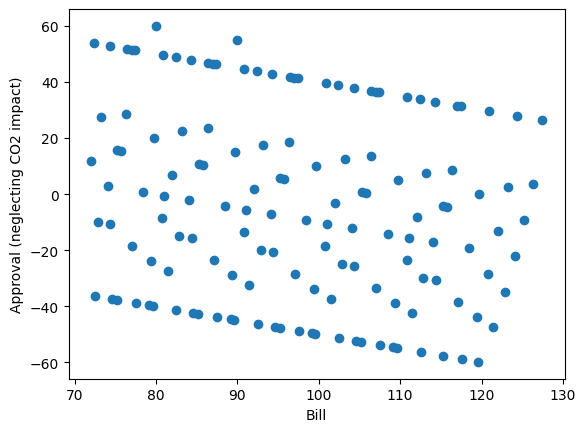

In [8]:
def summary_stats(tariff, carbon_credit_budget):
    """
    Calculate relevant stats for the tariff...

    Calculates the profit, approval, carbon credits, and bill of the tariff.
    """
    stats = {}
    # calculate the net emissions
    peak_consumption = tariff['consumed_peak']
    offpeak_consumption = tariff['consumed_offpeak']

    offpeak_intensity = 100  # g/kWh
    peak_intensity = 200  # g/kWh

    onpeak_credit_costs = 0.0005  # USD/g
    offpeak_credit_costs = 0.0005  # USD/g
    # calculate the net emissions
    emissions = peak_consumption * peak_intensity + offpeak_consumption * offpeak_intensity
    co2_disapproval = 0.001 * emissions  # 1/g
    bill_disapproval = 0.5 * tariff['bill']  # 1/USD
    approval = tariff['simplicity'] - co2_disapproval - bill_disapproval
    approval_co2_zero = tariff['simplicity'] - bill_disapproval

    stats['onpeak_consumption'] = peak_consumption
    stats['offpeak_consumption'] = offpeak_consumption
    stats['bill'] = tariff['bill']
    stats['emissions'] = emissions
    stats['onpeak_credit_costs'] = peak_consumption * peak_intensity * onpeak_credit_costs
    stats['offpeak_credit_costs'] = offpeak_consumption * offpeak_intensity * offpeak_credit_costs
    stats['total_credit_costs'] = stats['onpeak_credit_costs'] + stats['offpeak_credit_costs']
    stats['profit'] = tariff['profit']
    stats['bill_disapproval'] = bill_disapproval
    stats['co2_disapproval'] = co2_disapproval
    stats['approval_co2_zero'] = approval_co2_zero
    stats['approval'] = approval
    stats['tariff_id'] = tariff['tariff_id']
    stats['onpeak_price'] = tariff['onpeak_price']
    stats['offpeak_price'] = tariff['offpeak_price']
    stats['fixed_charge'] = tariff['fixed_charge']

    return stats

# calculate all summary stats and merge into a dataframe
summary_stats_df = pd.DataFrame(
    [summary_stats(tariff[1], 10) for tariff in tariff_set_df.reset_index().iterrows()]
)
summary_stats_df.set_index('tariff_id', inplace=True)
# Draw histogram of approvals where approval_co2_zero is greater than 0
summary_stats_df[summary_stats_df['approval_co2_zero'] > 0]['approval_co2_zero'].hist(bins=20)
plt.xlabel("Approval (neglecting CO2 impact)")

plt.figure()
# Draw histogram of bills where approval_co2_zero is greater than 0
summary_stats_df[summary_stats_df['approval_co2_zero'] > 0]['bill'].hist(bins=20)
plt.xlabel("Bill")

plt.figure()
# Scatterplot of bill vs. approval_co2_zero
plt.scatter(summary_stats_df['bill'], summary_stats_df['approval_co2_zero'])
plt.xlabel("Bill")
plt.ylabel("Approval (neglecting CO2 impact)")

# calculate the top three approved tariffs
summary_stats_df.sort_values('approval', ascending=False, inplace=True)
summary_stats_df.head(60)

# calculate the top three approved tariffs
# summary_stats_df.sort_values('approval', ascending=True, inplace=True)
# summary_stats_df.head(10)


In [ ]:
# Get dataframe where index is T0000000002 and T0000000008
summary_stats_df.loc[['T0000000002', 'T0000000008']]

# Make plot of the onpeak price and the fixed

,onpeak_consumption,offpeak_consumption,bill,emissions,onpeak_credit_costs,offpeak_credit_costs,total_credit_costs,profit,bill_disapproval,co2_disapproval,approval_co2_zero,approval,onpeak_price,offpeak_price,fixed_charge
tariff_id,,,,,,,,,,,,,,,
T0000000002,110.132281,27.069820,74.300525,24733.438180,11.013228,1.353491,12.366719,32.571814,37.150263,24.733438,52.849737,28.116299,0.25,0.25,40
T0000000008,191.687255,32.549982,72.423724,41592.449188,19.168726,1.627499,20.796225,30.695013,36.211862,41.592449,53.788138,12.195689,0.10,0.10,50


In [11]:
# Examing the top 10 approved tariffs where the fixed charge is 0
zero_fixedcosts = summary_stats_df[summary_stats_df['fixed_charge'] == 40]
# zero_fixedcosts.sort_values('approval', ascending=False, inplace=True)
zero_fixedcosts.head(13)


,onpeak_consumption,offpeak_consumption,bill,emissions,onpeak_credit_costs,offpeak_credit_costs,total_credit_costs,profit,bill_disapproval,co2_disapproval,approval_co2_zero,approval,onpeak_price,offpeak_price,fixed_charge
tariff_id,,,,,,,,,,,,,,,
T0000000007,98.633609,26.094810,77.418526,22336.202711,9.863361,1.304740,11.168101,35.689814,38.709263,22.336203,51.290737,28.954535,0.30,0.30,40
T0000000002,110.132281,27.069820,74.300525,24733.438180,11.013228,1.353491,12.366719,32.571814,37.150263,24.733438,52.849737,28.116299,0.25,0.25,40
T0000000006,98.633609,27.069820,76.357538,22433.703753,9.863361,1.353491,11.216852,34.628827,38.178769,22.433704,28.487898,6.054194,0.30,0.25,40
T0000000001,110.132281,28.312853,73.195641,24857.741420,11.013228,1.415643,12.428871,31.466930,36.597820,24.857741,27.402180,2.544438,0.25,0.20,40
T0000000005,98.633609,28.312853,75.252653,22558.006993,9.863361,1.415643,11.279003,33.523942,37.626327,22.558007,15.707007,-6.851000,0.30,0.20,40
T0000000000,110.132281,30.000000,72.033070,25026.456147,11.013228,1.500000,12.513228,30.304359,36.016535,25.026456,11.983465,-13.042991,0.25,0.15,40
T0000000004,98.633609,30.000000,74.090083,22726.721721,9.863361,1.500000,11.363361,32.361371,37.045041,22.726722,2.954959,-19.771763,0.30,0.15,40
T0000000003,98.633609,32.549982,72.845081,22981.719878,9.863361,1.627499,11.490860,31.116370,36.422540,22.981720,-9.755874,-32.737594,0.30,0.10,40


In [156]:
def to_mcdp_catalog(tariff_set, filepath, nmax=1000):
    catalog = {}
    catalog['F'] = ['Nat', 'USD']
    catalog['R'] = ['kWh', 'kWh', 'USD']
    catalog['implementations'] = {}

    total = len(tariff_set)
    for i, tariff in enumerate(tariff_set):
        if i % 5000 == 0 and i > 0:
            print(f"Generating tariff {i+1} of {total}...")
            print(tariff)
        info = {}
        info['f_max'] = [
            f"{int(tariff['simplicity'])} Nat",
            f"{float(tariff['profit']):.4f} USD"]
        info['r_min'] = [
            f"{float(tariff['consumed_peak']):.4f} kWh",
            f"{float(tariff['consumed_offpeak']):.4f} kWh",
            f"{float(tariff['bill']):.4f} USD",
        ]
        catalog['implementations'][tariff['tariff_id']] = info
        if i >= nmax:
            break

    with open(filepath, 'w') as f:
        yaml.dump(catalog, f)


fpath = '../tariff_design_v2.mcdplib/tariff/tariff.dpc.yaml'

to_mcdp_catalog(tariff_set,
                filepath=fpath,
                nmax=100000)
